# Importing Libraries

In [25]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import torch
import os
import xmltodict
import sys
import torch.optim as optim
import random

from torchvision import transforms
from torchvision import datasets,transforms,models
from torch.utils.data import Dataset,DataLoader
from PIL import Image
from collections import Counter


# Set the seed for reproducibility
seed = 2
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)


# Extraction of Images and Annotations

All the images are stored in img_names list and annotations in xml_names list.

In [26]:
img_names = []
xml_names = []

directory_path = 'C:\\Users\\Ritik\\Downloads\\CV project\\face-mask-detection'

for dirname, _, filenames in os.walk(directory_path):
    for filename in filenames:
        if filename.endswith('.xml'):
            xml_names.append(filename)
        else:
            img_names.append(filename)


In [27]:
path_annotations = "C:\\Users\\Ritik\\Downloads\\CV project\\face-mask-detection\\annotations\\"

listing = []

for img_name in img_names:
    xml_file_path = os.path.join(path_annotations, img_name[:-4] + ".xml")

    with open(xml_file_path) as fd:
        doc = xmltodict.parse(fd.read())

    objects = doc["annotation"]["object"]

    if isinstance(objects, list):
        listing.extend(obj["name"] for obj in objects)
    else:
        listing.append(objects["name"])

item_counts = Counter(listing)
Items = item_counts.keys()
values = item_counts.values()

print(Items, '\n', values)


dict_keys(['without_mask', 'with_mask', 'mask_weared_incorrect']) 
 dict_values([717, 3232, 123])


# Visualisation and Analysis of Target Class

Target classes belongs to :

* with mask 
* mask weared incorrect
* without mask

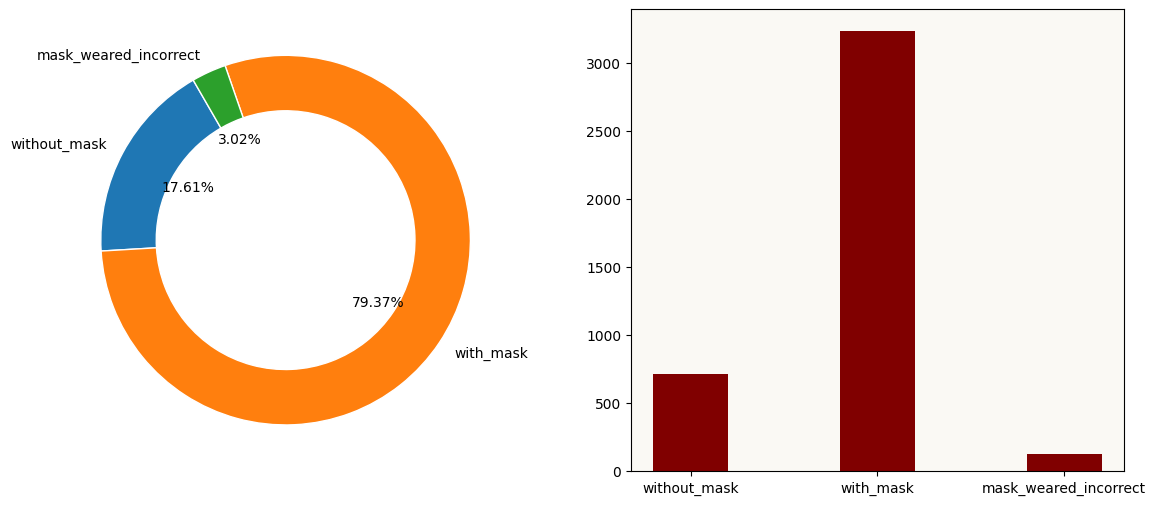

In [28]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Set the background color for the subplots
background_color = '#faf9f4'
ax1.set_facecolor(background_color)
ax2.set_facecolor(background_color)

# Plot a pie chart on the first subplot (ax1)
ax1.pie(values, wedgeprops=dict(width=0.3, edgecolor='w'),
        labels=Items, radius=1, startangle=120, autopct='%1.2f%%')

# Plot a bar chart on the second subplot (ax2)
ax2.bar(Items, list(values), color='maroon', width=0.4)

# Display the plots
plt.show()


Dataset contain images :

* with_mask : 79.37%
* mask_weared_incorrect : 3.02%
* without_mask : 17.61%

# Images Identification with Target Class

As there are 3 classes in target, we can use 3 colors for cascading the face.
* Red --> without_mask
* Green --> with_mask
* Yellow -- > mask_weared_incorrect

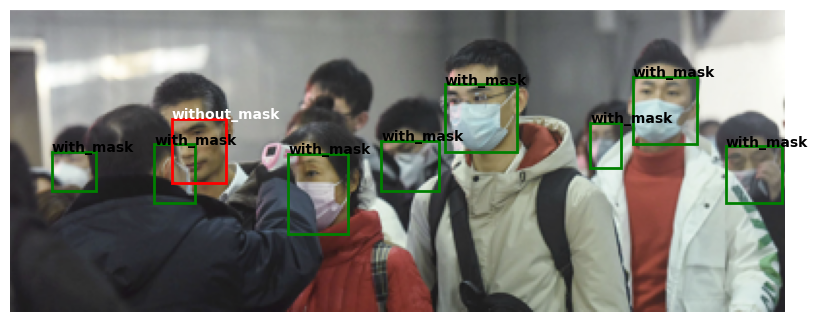

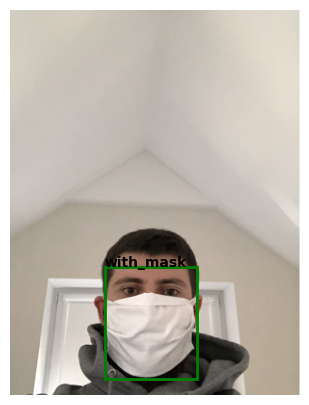

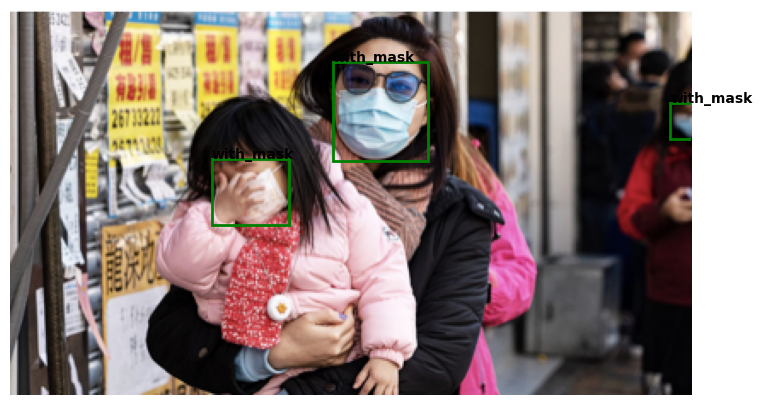

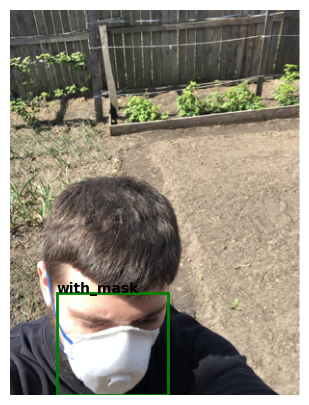

In [29]:
path_annotations = "C:\\Users\\Ritik\\Downloads\\CV project\\face-mask-detection\\annotations\\"
path_image = "C:\\Users\\Ritik\\Downloads\\CV project\\face-mask-detection\\images\\"

def draw_bounding_box(ax, label, x, y, w, h, edgecolor, text_color):
    mpatch = mpatches.Rectangle((x, y), w - x, h - y, linewidth=1, edgecolor=edgecolor, facecolor="none", lw=2)
    ax.add_patch(mpatch)
    rx, ry = mpatch.get_xy()
    ax.annotate(label, (rx, ry), color=text_color, weight='bold', fontsize=10, ha='left', va='baseline')

def plot_face_cas(image_path, xml_path):
    with open(xml_path) as fd:
        doc = xmltodict.parse(fd.read())
    image = plt.imread(image_path)
    
    fig, ax = plt.subplots(1)
    ax.axis("off")
    fig.set_size_inches(10, 5)
    
    objects = doc["annotation"]["object"]
    
    if isinstance(objects, list):
        for obj in objects:
            label = obj["name"]
            x, y, w, h = map(int, obj["bndbox"].values())
            edgecolor = {"with_mask": "g", "without_mask": "r", "mask_weared_incorrect": "y"}.get(label, 'w')
            text_color = 'white' if label == 'without_mask' else 'black'
            draw_bounding_box(ax, label, x, y, w, h, edgecolor, text_color)
    else:
        label = objects["name"]
        x, y, w, h = map(int, objects["bndbox"].values())
        edgecolor = {"with_mask": "g", "without_mask": "r", "mask_weared_incorrect": "y"}.get(label, 'w')
        text_color = 'white' if label == 'without_mask' else 'black'
        draw_bounding_box(ax, label, x, y, w, h, edgecolor, text_color)
    
    ax.imshow(image)

fun_images = img_names[1:5]  # Select the desired range of images
for img_name in fun_images:
    image_path = os.path.join(path_image, img_name)
    xml_path = os.path.join(path_annotations, img_name[:-4] + ".xml")
    plot_face_cas(image_path, xml_path)

plt.show()


# Image Preprocessing

In [30]:
# path_annotations = "C:\\Users\\Ritik\\Downloads\\CV project\\face-mask-detection\\annotations\\"
# path_image = "C:\\Users\\Ritik\\Downloads\\CV project\\face-mask-detection\\images\\"

options = {"with_mask": 0, "without_mask": 1, "mask_weared_incorrect": 2}

def load_image_and_label(image_filename, xml_path):
    with open(xml_path) as fd:
        doc = xmltodict.parse(fd.read())

    image_tensor = []
    label_tensor = []
    
    objects = doc["annotation"]["object"]

    if not isinstance(objects, list):
        objects = [objects]

    for obj in objects:
        x, y, w, h = map(int, obj["bndbox"].values())
        label = options.get(obj["name"], -1)
        image = transforms.functional.crop(
            Image.open(os.path.join(path_image, image_filename)).convert("RGB"),
            y, x, h - y, w - x
        )
        image_tensor.append(my_transform(image))
        label_tensor.append(torch.tensor(label))

    return image_tensor, label_tensor

def dataset_creation(image_list):
    image_tensors = []
    label_tensors = []

    for image_filename in image_list:
        xml_path = os.path.join(path_annotations, image_filename[:-4] + ".xml")
        image_tensor, label_tensor = load_image_and_label(image_filename, xml_path)
        image_tensors.extend(image_tensor)
        label_tensors.extend(label_tensor)

    final_dataset = list(zip(image_tensors, label_tensors))
    return tuple(final_dataset)

my_transform = transforms.Compose([
    transforms.Resize((226, 226)),
    transforms.ToTensor()
])

mydataset = dataset_creation(img_names)


In [31]:
mydataset[0]

(tensor([[[0.4941, 0.4941, 0.4941,  ..., 0.6157, 0.6157, 0.6157],
          [0.4941, 0.4941, 0.4941,  ..., 0.6157, 0.6157, 0.6157],
          [0.4941, 0.4941, 0.4941,  ..., 0.6157, 0.6157, 0.6157],
          ...,
          [0.1843, 0.1843, 0.1843,  ..., 0.3216, 0.3216, 0.3216],
          [0.1843, 0.1843, 0.1843,  ..., 0.3216, 0.3216, 0.3216],
          [0.1843, 0.1843, 0.1843,  ..., 0.3216, 0.3216, 0.3216]],
 
         [[0.4431, 0.4431, 0.4431,  ..., 0.5216, 0.5216, 0.5216],
          [0.4431, 0.4431, 0.4431,  ..., 0.5216, 0.5216, 0.5216],
          [0.4431, 0.4431, 0.4431,  ..., 0.5216, 0.5216, 0.5216],
          ...,
          [0.1216, 0.1216, 0.1216,  ..., 0.1647, 0.1647, 0.1647],
          [0.1216, 0.1216, 0.1216,  ..., 0.1647, 0.1647, 0.1647],
          [0.1216, 0.1216, 0.1216,  ..., 0.1647, 0.1647, 0.1647]],
 
         [[0.4784, 0.4784, 0.4784,  ..., 0.5216, 0.5216, 0.5216],
          [0.4784, 0.4784, 0.4784,  ..., 0.5216, 0.5216, 0.5216],
          [0.4784, 0.4784, 0.4784,  ...,

# Splitting Dataset into Training and Test Set

In [32]:
total_size = len(mydataset)
train_size = int(total_size * 0.7)
test_size = total_size - train_size

print('Length of dataset is', total_size)
print('Length of training set is:', train_size)
print('Length of test set is:', test_size)


Length of dataset is 4072
Length of training set is: 2850
Length of test set is: 1222


In [33]:
trainset,testset=torch.utils.data.random_split(mydataset,[train_size,test_size])

# Samples in Training Set

In [34]:

train_dataloader =DataLoader(dataset=trainset,batch_size=32,shuffle=True,num_workers=4)
test_dataloader =DataLoader(dataset=testset,batch_size=32,shuffle=True,num_workers=4)

In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available()
                               else "cpu")

In [36]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([32, 3, 226, 226])
Labels batch shape: torch.Size([32])


In [37]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Convert the batch of features to a NumPy array
train_features_np = train_features.numpy()

# Create a figure to display the images
fig, axes = plt.subplots(1, 5, figsize=(25, 4))

# Iterate through and display the images
for idx, ax in enumerate(axes):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(np.transpose(train_features_np[idx], (1, 2, 0)))

plt.show()


# Training Model

In [38]:
# Download the resnet34 layers pre-trained model
model=models.resnet34(pretrained=True)

# Feature Extraction
for param in model.parameters():
    param.requires_grad=False


import torch.nn as nn

# Define the new linear layer with 3 output features
n_inputs=model.fc.in_features
last_layer=nn.Linear(n_inputs,3)

# Replace the model's output layer with the new linear layer
model.fc.out_features=last_layer
print('reinitialize model with output features as 3 :', model.fc.out_features)


features_resnet34 = []
for key,value in model._modules.items():
    features_resnet34.append(value)

# Calculating Parameters of 2D-Convolutional Layer 
conv_param = 64 * 128 * 3 * 3
print(' Number of Parameters for conv2D is :', conv_param )

# CrossEntropyLoss
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.01)


param.requires_grad=True
ct = 0
for child in model.children():
    ct += 1
    if ct < 7:
        for param in child.parameters():
            param.requires_grad = False

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# If available, move the model to GPU
if torch.cuda.is_available():
    model = model.cuda()

# Training loop
train_losses = []

for epoch in range(1, 11):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_dataloader):
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if i % 20 == 19:
            print("Epoch {}, batch {}, training loss {:.4f}".format(epoch, i + 1, running_loss / 20))
            running_loss = 0.0

    train_losses.append(running_loss/10)

    # Save the model state after each epoch
    torch.save(model.state_dict(), f'model_epoch_{epoch}.pth')

print('\nFinished Training')

# Train Loss plot
plt.figure(figsize=(10, 5))
plt.title("Train Loss")
plt.plot(train_losses, label="Train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()



reinitialize model with output features as 3 : Linear(in_features=512, out_features=3, bias=True)
 Number of Parameters for conv2D is : 73728
Epoch 1, batch 20, training loss 9.2377
Epoch 1, batch 40, training loss 8.9379
Epoch 1, batch 60, training loss 8.5063
Epoch 1, batch 80, training loss 8.0708
Epoch 2, batch 20, training loss 7.5754
Epoch 2, batch 40, training loss 7.1613
Epoch 2, batch 60, training loss 6.8527
Epoch 2, batch 80, training loss 6.5384
Epoch 3, batch 20, training loss 5.9982
Epoch 3, batch 40, training loss 5.5952
Epoch 3, batch 60, training loss 5.2201
Epoch 3, batch 80, training loss 4.9537
Epoch 4, batch 20, training loss 4.4982
Epoch 4, batch 40, training loss 4.1754
Epoch 4, batch 60, training loss 3.8906
Epoch 4, batch 80, training loss 3.5689
Epoch 5, batch 20, training loss 3.1580
Epoch 5, batch 40, training loss 2.9935
Epoch 5, batch 60, training loss 2.8711
Epoch 5, batch 80, training loss 2.6486
Epoch 6, batch 20, training loss 2.3229
Epoch 6, batch 40,

## Testing model

In [39]:
import torch
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the trained model (use the checkpoint corresponding to the desired epoch)
model.load_state_dict(torch.load('model_epoch_10.pth'))  # Use the checkpoint for epoch
model.eval()

# Define lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Evaluate the model on the test dataset
with torch.no_grad():
    for inputs, labels in test_dataloader:
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy * 100:.2f}%')

class_names = ["class1", "class2", "class3"]
confusion_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix with numbers in normal format
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix[:3, :3], annot=True, fmt='d', cmap='Blues', xticklabels=class_names[:3], yticklabels=class_names[:3])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Accuracy: 70.29%
